In [60]:
import pandas as pd
#Procesado y modelo
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score

In [61]:
datos = pd.read_csv('df.csv')
datos.head(3)

,Unnamed: 0,backers_count,id_creator,blurb,main_category,subcategory,converted_pledged_amount,loc_state,loc_name,loc_type,...,staff_pick,state,state_changed_at,static_usd_rate,url_projects,url_rewards,usd_exchange_rate,usd_pledged,usd_type,city_sponsor
0,0,6,2140458295,Introducing a Black-Queer-owned co-op that amp...,Theater,Spaces,403.0,CO,Denver,Town,...,True,live,2023-02-12 04:04:47,1.0,https://www.kickstarter.com/projects/thechrysa...,https://www.kickstarter.com/projects/thechrysa...,1.0,403.0,domestic,"[('Denver Estados Unidos', '12'), ('San Franci..."
1,1,345,1242702247,"A cozy bookstore in historic Grapevine, Texas,...",Theater,Spaces,54100.0,TX,Grapevine,Town,...,True,successful,2022-10-17 22:05:29,1.0,https://www.kickstarter.com/projects/talkingan...,https://www.kickstarter.com/projects/talkingan...,1.0,54100.0,domestic,"[('New York Estados Unidos', '16'), ('Dallas E..."
2,2,73,1475363581,We are building out our own theatre space in A...,Theater,Spaces,25265.0,GA,Acworth,Town,...,False,successful,2022-05-26 22:00:00,1.0,https://www.kickstarter.com/projects/fireflyth...,https://www.kickstarter.com/projects/fireflyth...,1.0,25265.0,domestic,"[('Marietta Estados Unidos', '9'), ('Atlanta E..."


In [62]:
#Elimino la primera columna
datos = datos[datos.columns[1:]]

In [63]:
df = datos.drop(['url_projects','id_creator','blurb','country_displayable_name','url_rewards','source_url','slug','currency','country','profile','usd_exchange_rate', 'currency_trailing_code','id', 'name'], axis=1)

In [64]:
df['static_usd_rate'] = df['static_usd_rate'].apply(lambda x: bool(x))

In [65]:
df.head(2)

,backers_count,main_category,subcategory,converted_pledged_amount,loc_state,loc_name,loc_type,created_at,current_currency,deadline,...,permissions,pledged,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_pledged,usd_type,city_sponsor
0,6,Theater,Spaces,403.0,CO,Denver,Town,2023-01-31 05:08:41,USD,2023-04-01 05:59:00,...,NaN,403.0,False,True,live,2023-02-12 04:04:47,True,403.0,domestic,"[('Denver Estados Unidos', '12'), ('San Franci..."
1,345,Theater,Spaces,54100.0,TX,Grapevine,Town,2022-07-13 17:44:19,USD,2022-10-17 22:05:28,...,NaN,54100.0,True,True,successful,2022-10-17 22:05:29,True,54100.0,domestic,"[('New York Estados Unidos', '16'), ('Dallas E..."


In [66]:
for columna in df.columns.values:
    if len(list(df[columna].describe())) == 4: # significa que es variable categórica
        if list(df[columna].describe())[3] >= list(df[columna].describe())[0]*0.95:
            df = df.drop(columna, axis=1)
            print(columna,'eliminada')

loc_type eliminada
current_currency eliminada
disable_communication eliminada
friends eliminada
is_backing eliminada
is_starred eliminada
permissions eliminada


In [67]:
df.head(3)

,backers_count,main_category,subcategory,converted_pledged_amount,loc_state,loc_name,created_at,deadline,fx_rate,goal,...,launched_at,pledged,spotlight,staff_pick,state,state_changed_at,static_usd_rate,usd_pledged,usd_type,city_sponsor
0,6,Theater,Spaces,403.0,CO,Denver,2023-01-31 05:08:41,2023-04-01 05:59:00,1.0,50000,...,2023-02-12 04:04:44,403.0,False,True,live,2023-02-12 04:04:47,True,403.0,domestic,"[('Denver Estados Unidos', '12'), ('San Franci..."
1,345,Theater,Spaces,54100.0,TX,Grapevine,2022-07-13 17:44:19,2022-10-17 22:05:28,1.0,50000,...,2022-09-05 22:05:28,54100.0,True,True,successful,2022-10-17 22:05:29,True,54100.0,domestic,"[('New York Estados Unidos', '16'), ('Dallas E..."
2,73,Theater,Spaces,25265.0,GA,Acworth,2022-04-09 21:14:36,2022-05-26 22:00:00,1.0,25000,...,2022-05-12 18:28:01,25265.0,True,False,successful,2022-05-26 22:00:00,True,25265.0,domestic,"[('Marietta Estados Unidos', '9'), ('Atlanta E..."


In [68]:
df['created_at'] = df['created_at'].astype('datetime64[ns]')
df['deadline'] = df['deadline'].astype('datetime64[ns]')
df['state_changed_at'] = df['state_changed_at'].astype('datetime64[ns]')
df['launched_at'] = df['launched_at'].astype('datetime64[ns]')

df['tiempo_max'] = df['deadline'] - df['created_at']
df['tiempo_max'] = (df['tiempo_max'].astype('int64')//86400000000000) #ese número es para pasarlo a dias porque está en ns

df['tiempo_cambio'] = df['state_changed_at'] - df['created_at']
df['tiempo_cambio'] = (df['tiempo_cambio'].astype('int64')//86400000000000)

df['tiempo_creacion'] = df['launched_at'] - df['created_at']
df['tiempo_creacion'] = (df['tiempo_creacion'].astype('int64')//86400000000000)

df = df.drop(['created_at', 'deadline', 'state_changed_at', 'launched_at'], axis=1)

In [69]:
for columna in df.columns.values:
    print(columna,': ',df[columna].dtype)

backers_count :  int64
main_category :  object
subcategory :  object
converted_pledged_amount :  float64
loc_state :  object
loc_name :  object
fx_rate :  float64
goal :  int64
is_starrable :  bool
pledged :  float64
spotlight :  bool
staff_pick :  bool
state :  object
static_usd_rate :  bool
usd_pledged :  float64
usd_type :  object
city_sponsor :  object
tiempo_max :  int64
tiempo_cambio :  int64
tiempo_creacion :  int64


In [70]:
df.head(2)

,backers_count,main_category,subcategory,converted_pledged_amount,loc_state,loc_name,fx_rate,goal,is_starrable,pledged,spotlight,staff_pick,state,static_usd_rate,usd_pledged,usd_type,city_sponsor,tiempo_max,tiempo_cambio,tiempo_creacion
0,6,Theater,Spaces,403.0,CO,Denver,1.0,50000,True,403.0,False,True,live,True,403.0,domestic,"[('Denver Estados Unidos', '12'), ('San Franci...",60,11,11
1,345,Theater,Spaces,54100.0,TX,Grapevine,1.0,50000,False,54100.0,True,True,successful,True,54100.0,domestic,"[('New York Estados Unidos', '16'), ('Dallas E...",96,96,54


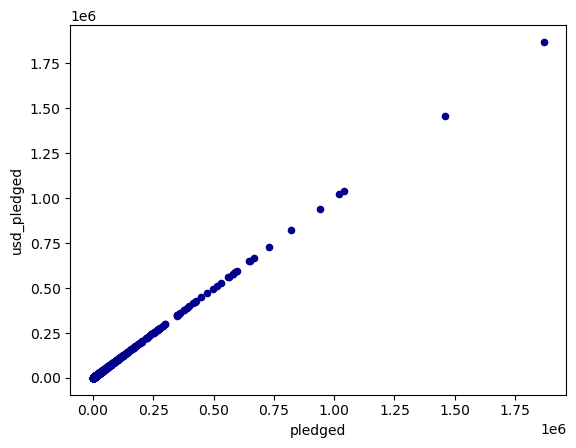

In [71]:
ax1 = df.plot.scatter(x='pledged', y='usd_pledged', c='DarkBlue')

Linealidad perfecta, borramos una variable, ya que no es útil. Dan la misma información y pueden dar problemas de multicolinealidad

In [72]:
df = df.drop('usd_pledged', axis = 1)

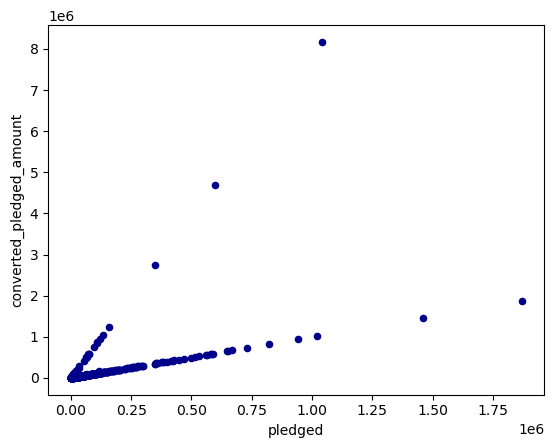

In [73]:
ax1 = df.plot.scatter(x='pledged', y='converted_pledged_amount', c='DarkBlue')

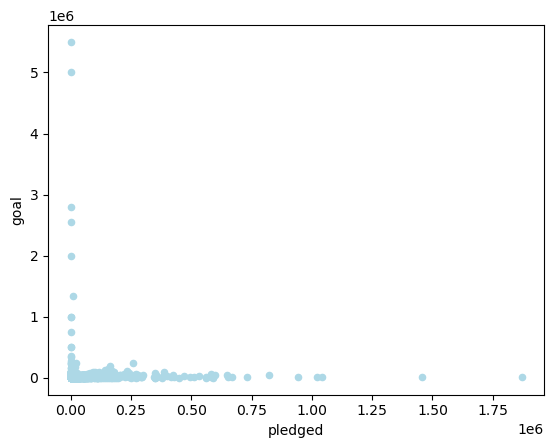

In [74]:
ax1 = df.plot.scatter(x='pledged', y='goal', c= 'lightblue')

In [75]:
pledged = df['pledged']
df = df.drop(['converted_pledged_amount', 'pledged'], axis=1)
df2 = df.copy()

In [76]:
s = {}
for i in range(len(df)):
    lista = eval(df['city_sponsor'][i])
    for lugar, num in lista:
        if lugar not in s:
            s[lugar] = 1
        else:
            s[lugar] += 1

In [77]:
s_ord = dict(sorted(s.items(), key=lambda item: item[1], reverse=True))
s_ord

{'Los Angeles Estados Unidos': 925,
 'New York Estados Unidos': 713,
 'Chicago Estados Unidos': 705,
 'San Francisco Estados Unidos': 658,
 'London Reino Unido': 620,
 'Seattle Estados Unidos': 556,
 'Toronto Canadá': 454,
 'Sydney Australia': 374,
 'Melbourne Australia': 367,
 'Portland Estados Unidos': 339,
 'Brooklyn Estados Unidos': 332,
 'Austin Estados Unidos': 282,
 'Singapore Singapur': 253,
 'Houston Estados Unidos': 239,
 'Minneapolis Estados Unidos': 238,
 'Boston Estados Unidos': 236,
 'Denver Estados Unidos': 230,
 'Atlanta Estados Unidos': 229,
 'Dallas Estados Unidos': 159,
 'Montreal Canadá': 159,
 'San Diego Estados Unidos': 141,
 'San Jose Estados Unidos': 135,
 'Brisbane Australia': 133,
 'Washington Estados Unidos': 131,
 'Philadelphia Estados Unidos': 131,
 'Vancouver Canadá': 101,
 'Paris Francia': 99,
 'Calgary Canadá': 97,
 'Queens Estados Unidos': 95,
 'Albuquerque Estados Unidos': 92,
 'Columbus Estados Unidos': 88,
 'Phoenix Estados Unidos': 88,
 'Arlington E

In [78]:
n = 15
lista_top = []
for lugar in s_ord:
    if len(lista_top)==n:
        break
    lista_top.append(lugar)
    

In [79]:
lista_top

['Los Angeles Estados Unidos',
 'New York Estados Unidos',
 'Chicago Estados Unidos',
 'San Francisco Estados Unidos',
 'London Reino Unido',
 'Seattle Estados Unidos',
 'Toronto Canadá',
 'Sydney Australia',
 'Melbourne Australia',
 'Portland Estados Unidos',
 'Brooklyn Estados Unidos',
 'Austin Estados Unidos',
 'Singapore Singapur',
 'Houston Estados Unidos',
 'Minneapolis Estados Unidos']

In [80]:
dic_valores = {}
for elem in lista_top:
    dic_valores[elem] = [0]*len(df)

In [81]:
for i in range(len(df)):
    lista = eval(df['city_sponsor'][i])
    for lugar, num in lista:
        if lugar in dic_valores:
            dic_valores[lugar][i] = int(num)

In [82]:
len(dic_valores['Los Angeles Estados Unidos'])

2616

In [83]:
for lugar, num in dic_valores.items():
    df[lugar] = num

In [84]:
df

,backers_count,main_category,subcategory,loc_state,loc_name,fx_rate,goal,is_starrable,spotlight,staff_pick,...,Seattle Estados Unidos,Toronto Canadá,Sydney Australia,Melbourne Australia,Portland Estados Unidos,Brooklyn Estados Unidos,Austin Estados Unidos,Singapore Singapur,Houston Estados Unidos,Minneapolis Estados Unidos
0,6,Theater,Spaces,CO,Denver,1.0,50000,True,False,True,...,0,1,0,0,0,0,0,0,0,0
1,345,Theater,Spaces,TX,Grapevine,1.0,50000,False,True,True,...,0,0,0,0,0,5,3,0,0,0
2,73,Theater,Spaces,GA,Acworth,1.0,25000,False,True,False,...,0,0,0,0,0,0,0,0,0,0
3,200,Theater,Spaces,LA,Lafayette,1.0,15000,False,True,True,...,0,0,0,0,0,0,8,0,0,0
4,58,Theater,Spaces,OH,Columbus,1.0,7100,False,True,True,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2611,0,Comics,Webcomics,VA,Lynchburg,1.0,100,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2612,38,Comics,Webcomics,CA,Los Angeles,1.0,12000,False,False,True,...,3,1,1,0,0,0,1,0,0,0
2613,1,Comics,Webcomics,FL,Miami,1.0,7000,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2614,4,Comics,Webcomics,OH,Cincinnati,1.0,500,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [85]:
df = df.drop(['city_sponsor'], axis=1)

In [86]:
for columna in df.columns.values:
    if df[columna].dtype == object:
        df[columna] = df[columna].astype('category')

In [87]:
for columna in df.columns.values:    
    print(columna,': ',df[columna].dtype)

backers_count :  int64
main_category :  category
subcategory :  category
loc_state :  category
loc_name :  category
fx_rate :  float64
goal :  int64
is_starrable :  bool
spotlight :  bool
staff_pick :  bool
state :  category
static_usd_rate :  bool
usd_type :  category
tiempo_max :  int64
tiempo_cambio :  int64
tiempo_creacion :  int64
Los Angeles Estados Unidos :  int64
New York Estados Unidos :  int64
Chicago Estados Unidos :  int64
San Francisco Estados Unidos :  int64
London Reino Unido :  int64
Seattle Estados Unidos :  int64
Toronto Canadá :  int64
Sydney Australia :  int64
Melbourne Australia :  int64
Portland Estados Unidos :  int64
Brooklyn Estados Unidos :  int64
Austin Estados Unidos :  int64
Singapore Singapur :  int64
Houston Estados Unidos :  int64
Minneapolis Estados Unidos :  int64


In [88]:
df = df.dropna()
X = df.drop('state', axis=1)
y = df['state']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

In [40]:
# Crear el modelo
clf = DecisionTreeClassifier(random_state=42)
parametros_a = {'criterion': ('entropy', 'gini'),
             'max_depth': (2,10,20,50,100)}

rejilla_arbol = GridSearchCV(clf,
                      parametros_a,
                      scoring = 'accuracy')

# Entrenar el modelo con los datos de entrenamiento
rejilla_arbol.fit(X_train_encoded, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ('entropy', 'gini'),
                         'max_depth': (2, 10, 20, 50, 100)},
             scoring='accuracy')

In [41]:
rejilla_arbol.best_score_,rejilla_arbol.best_params_

(0.9870868980161228, {'criterion': 'entropy', 'max_depth': 10})

In [42]:
clf = DecisionTreeClassifier(max_depth=10, criterion='entropy', random_state=42)
clf.fit(X_train_encoded, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

In [43]:
# Hacer predicciones con los datos de prueba
y_pred = clf.predict(X_test_encoded)

# Calcular la precisión, la recuperación y la puntuación F1
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Precisión:", precision)
print("Recuperación:", recall)
print("Puntuación F1:", f1)
print("Exactitud:", accuracy)

Precisión: 0.9246376811594202
Recuperación: 0.9246376811594202
Puntuación F1: 0.9246376811594202
Exactitud: 0.9761904761904762


In [44]:
matriz_confusion = confusion_matrix(y_test, y_pred)
matriz_confusion

array([[  9,   6,   0,   0,   0,   0],
       [  6, 109,   0,   0,   0,   0],
       [  0,   0,  16,   0,   0,   0],
       [  0,   0,   0,   4,   0,   0],
       [  0,   0,   0,   0,  34,   0],
       [  0,   0,   0,   0,   0, 320]], dtype=int64)

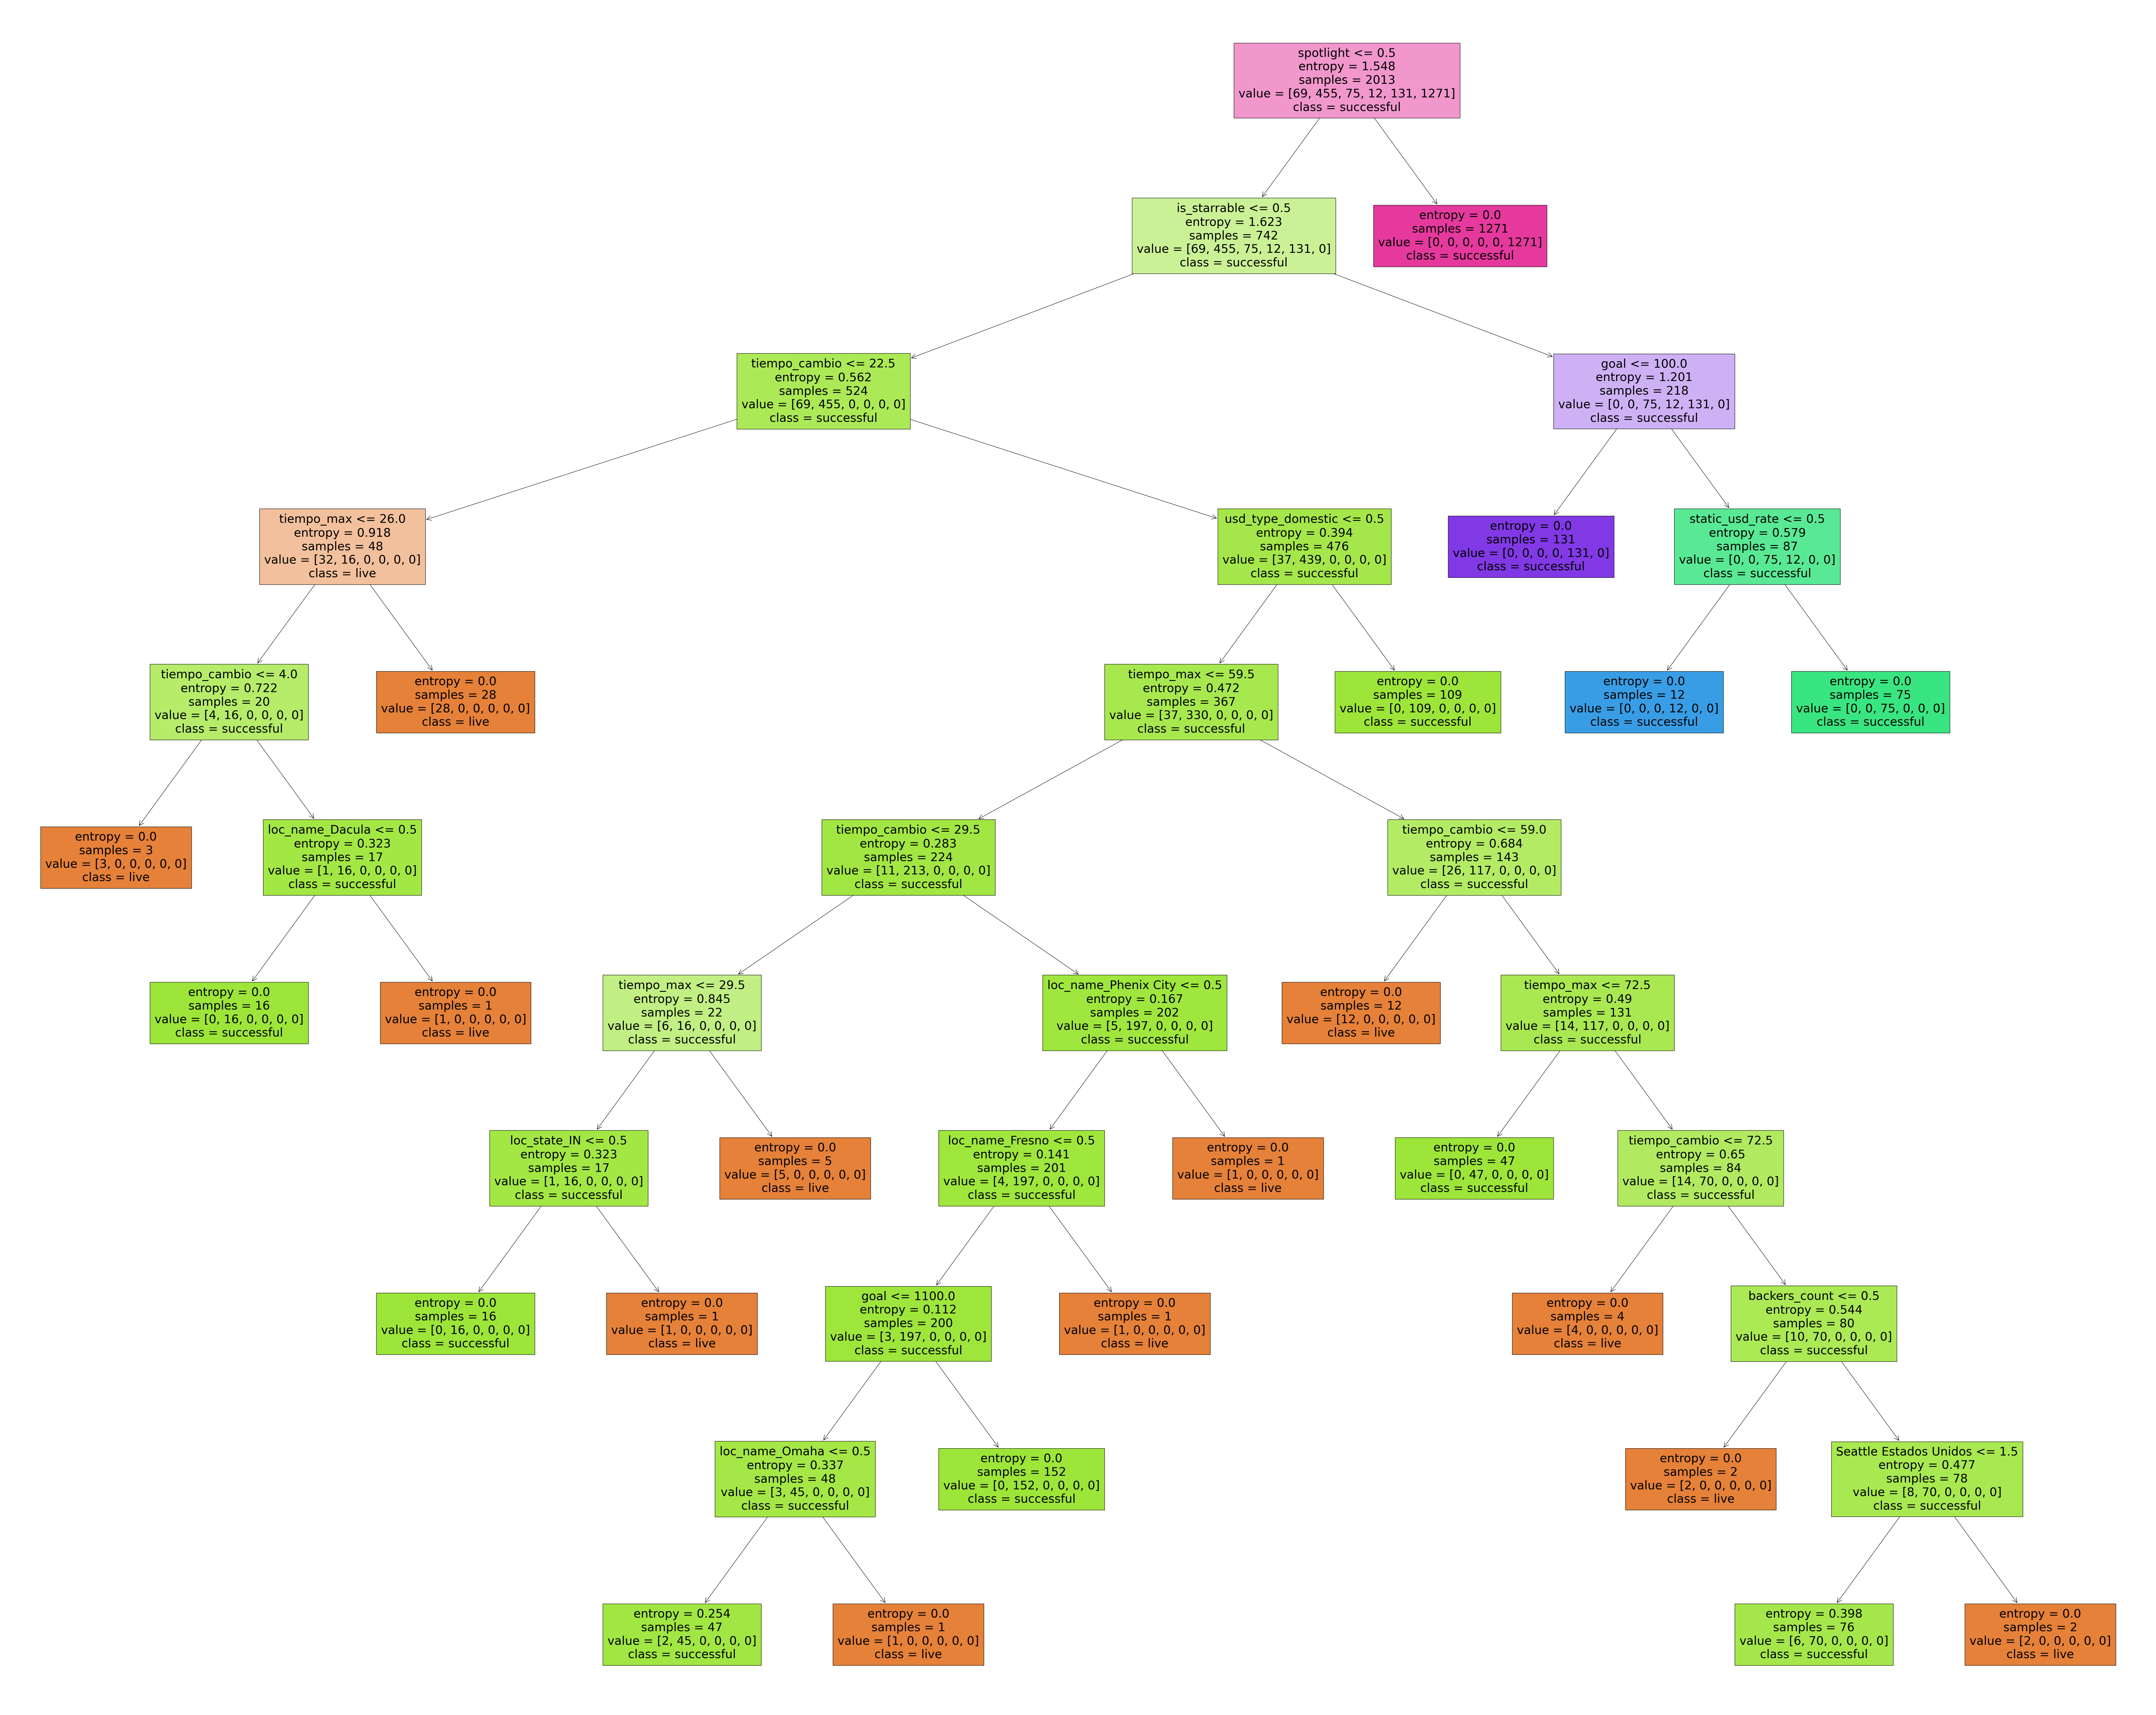

In [63]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(25*4,20*4))
plot_tree(clf, feature_names= list(X_train_encoded.columns.values),
                class_names= list(y.values),filled = True)
plt.show()

In [49]:
logreg = LogisticRegression()

# Ajustar el modelo a los datos de entrenamiento
logreg.fit(X_train_encoded, y_train)

# Realizar predicciones con los datos de prueba
y_pred = logreg.predict(X_test_encoded)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Obtener la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Accuracy: 0.8313492063492064
Confusion matrix:
 [[  0  13   0   0   0   2]
 [  0  64   0   0   0  51]
 [  0   8   0   0   0   8]
 [  0   0   0   4   0   0]
 [  0   0   0   0  34   0]
 [  0   3   0   0   0 317]]


C:\Users\dagun\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
df['pledged'] = pledged
X = df.drop(['pledged', 'state'], axis=1)
y = df['pledged']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

In [375]:
reg = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento
reg.fit(X_train_encoded, y_train)

# Realizar predicciones con los datos de prueba
y_pred = reg.predict(X_test_encoded)

for i,elem in enumerate(y_pred):
    if elem < 0:
        y_pred[i] = 0

# Evaluar la precisión del modelo
r2 = r2_score(y_test, y_pred)
print("R^2 score:", r2)

R^2 score: -0.49997409690480854


In [45]:
import seaborn as sns

sns.histplot(data = df, x = 'pledged', log_scale = True)
plt.title('Distribución de x')
plt.xlabel('Valor de x')
plt.ylabel('Frecuencia')
plt.xscale('log')
plt.yscale('log')
plt.show()

ValueError: Could not interpret value `pledged` for parameter `x`

In [371]:
y_pred

array([-4.27689994e+04,  1.15723596e+04, -2.20939286e+04,  2.24309855e+04,
       -1.29656223e+05, -2.49107796e+05,  1.09749941e+04, -4.57006320e+03,
       -3.80733212e+03,  5.53667310e+03,  3.42191297e+04,  4.83656706e+04,
        5.57146027e+04, -8.03024274e+03,  2.92984660e+04,  1.07712834e+04,
        2.75519356e+04, -2.10495760e+05,  8.16288489e+03,  3.70528937e+03,
       -2.21673769e+05,  2.16711140e+04, -1.03338898e+03,  5.12504128e+04,
        6.73397857e+04, -1.61115777e+04, -4.49160400e+03,  1.77324358e+04,
        3.17511609e+05,  6.22303501e+04, -3.20782394e+03, -1.29407935e+04,
        2.25023298e+04,  7.67675061e+03,  2.56209832e+05,  2.82214996e+04,
        2.68747151e+04,  3.43412856e+05,  5.37799072e+00, -8.87396048e+03,
        4.28491175e+04,  3.12216665e+05,  1.40477710e+04,  4.17273700e+04,
       -4.54689023e+03,  4.55536563e+04, -6.51189543e+04, -7.35190971e+04,
        1.19883904e+05,  2.74928629e+05,  3.58262954e+04,  1.69069429e+04,
       -3.60931339e+05,  

In [69]:
X2 = X_train_encoded
X2.to_csv('df_modelo.csv')

In [47]:
from rulefit import RuleFit

In [61]:
rf = RuleFit(model_type = 'logistic')
features = X_train_encoded.columns
features

Index(['backers_count', 'fx_rate', 'goal', 'is_starrable', 'spotlight',
       'staff_pick', 'static_usd_rate', 'tiempo_max', 'tiempo_cambio',
       'tiempo_creacion',
       ...
       'loc_name_Winterset', 'loc_name_Woodbury', 'loc_name_Woodruff',
       'loc_name_Woodstock', 'loc_name_Worcester', 'loc_name_Wyckoff',
       'loc_name_Wyoming', 'loc_name_Ypsilanti', 'usd_type_domestic',
       'usd_type_international'],
      dtype='object', length=857)

In [67]:
rf.fit(X_train_encoded*1, y_train,features)

InvalidIndexError: (slice(None, None, None), 0)

In [41]:
X.drop(['spotlight'], axis=1)

,backers_count,main_category,subcategory,loc_state,loc_name,fx_rate,goal,is_starrable,staff_pick,static_usd_rate,...,Seattle Estados Unidos,Toronto Canadá,Sydney Australia,Melbourne Australia,Portland Estados Unidos,Brooklyn Estados Unidos,Austin Estados Unidos,Singapore Singapur,Houston Estados Unidos,Minneapolis Estados Unidos
0,6,Theater,Spaces,CO,Denver,1.0,50000,True,True,True,...,0,1,0,0,0,0,0,0,0,0
1,345,Theater,Spaces,TX,Grapevine,1.0,50000,False,True,True,...,0,0,0,0,0,5,3,0,0,0
2,73,Theater,Spaces,GA,Acworth,1.0,25000,False,False,True,...,0,0,0,0,0,0,0,0,0,0
3,200,Theater,Spaces,LA,Lafayette,1.0,15000,False,True,True,...,0,0,0,0,0,0,8,0,0,0
4,58,Theater,Spaces,OH,Columbus,1.0,7100,False,True,True,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2611,0,Comics,Webcomics,VA,Lynchburg,1.0,100,False,False,True,...,0,0,0,0,0,0,0,0,0,0
2612,38,Comics,Webcomics,CA,Los Angeles,1.0,12000,False,True,True,...,3,1,1,0,0,0,1,0,0,0
2613,1,Comics,Webcomics,FL,Miami,1.0,7000,False,False,True,...,0,0,0,0,0,0,0,0,0,0
2614,4,Comics,Webcomics,OH,Cincinnati,1.0,500,False,False,True,...,0,0,0,0,0,0,0,0,0,0


In [34]:
X_train, X_test, y_train, y_test = train_test_split(x2, y, test_size=0.2, random_state=42)

In [35]:
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

In [36]:
# Crear el modelo
clf = DecisionTreeClassifier(random_state=42)
parametros_a = {'criterion': ('entropy', 'gini'),
             'max_depth': (2,10,20,50,100)}

rejilla_arbol = GridSearchCV(clf,
                      parametros_a,
                      scoring = 'accuracy')

# Entrenar el modelo con los datos de entrenamiento
rejilla_arbol.fit(X_train_encoded, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ('entropy', 'gini'),
                         'max_depth': (2, 10, 20, 50, 100)},
             scoring='accuracy')

In [37]:
rejilla_arbol.best_score_,rejilla_arbol.best_params_

(0.9195227337259114, {'criterion': 'entropy', 'max_depth': 20})

In [38]:
# Hacer predicciones con los datos de prueba
y_pred = rejilla_arbol.predict(X_test_encoded)

# Calcular la precisión, la recuperación y la puntuación F1
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Precisión:", precision)
print("Recuperación:", recall)
print("Puntuación F1:", f1)
print("Exactitud:", accuracy)

Precisión: 0.872008547008547
Recuperación: 0.8641304347826088
Puntuación F1: 0.8676929392446634
Exactitud: 0.9126984126984127


In [39]:
matriz_confusion = confusion_matrix(y_test, y_pred)
matriz_confusion

array([[  6,   8,   0,   0,   0,   1],
       [  4,  96,   0,   0,   0,  15],
       [  0,   0,  16,   0,   0,   0],
       [  0,   0,   0,   4,   0,   0],
       [  0,   0,   0,   0,  34,   0],
       [  3,  13,   0,   0,   0, 304]], dtype=int64)

In [46]:
from sklearn.cross_decomposition import PLSRegression as PLS

In [49]:
pls1 = PLS(n_components = 2)

In [54]:
y = []
for elem in y_train:
    if elem == 'canceled':
        y.append(0)
    elif elem == 'failed':
        y.append(1)
    elif elem == 'live':
        y.append(2)
    elif elem == 'started':
        y.append(3)
    elif elem == 'submitted':
        y.append(4)
    else:
        y.append(5)

In [57]:
pls1.fit(X_train_encoded,y)

PLSRegression()

In [58]:
pls1.predict(X_test_encoded)

array([[ 3.30278954],
       [ 2.76282528],
       [ 3.2133269 ],
       [ 5.10592312],
       [ 4.78250895],
       [ 1.36835417],
       [ 4.03063568],
       [ 3.38832224],
       [ 5.05742012],
       [ 1.98418837],
       [ 4.13402461],
       [ 4.06443037],
       [ 4.84648128],
       [ 2.37263006],
       [ 5.98176673],
       [ 3.14089136],
       [ 5.45905744],
       [ 2.74470629],
       [ 4.59515919],
       [ 4.40393072],
       [ 1.62885661],
       [ 3.8410554 ],
       [ 3.01981013],
       [ 3.08750212],
       [ 1.96073158],
       [ 2.62979504],
       [ 3.11405626],
       [ 5.38190254],
       [ 2.60522971],
       [ 3.48407472],
       [ 1.04694591],
       [ 4.14378814],
       [ 4.89506543],
       [ 4.86681711],
       [ 6.66722616],
       [ 4.71304376],
       [ 5.25710035],
       [ 3.19631308],
       [ 4.38587986],
       [ 3.4422099 ],
       [ 4.44229164],
       [ 3.23306962],
       [ 4.73185647],
       [ 3.86555741],
       [ 1.30146712],
       [ 4

,backers_count,main_category,subcategory,loc_state,loc_name,fx_rate,goal,is_starrable,spotlight,staff_pick,...,Seattle Estados Unidos,Toronto Canadá,Sydney Australia,Melbourne Australia,Portland Estados Unidos,Brooklyn Estados Unidos,Austin Estados Unidos,Singapore Singapur,Houston Estados Unidos,Minneapolis Estados Unidos
0,6,Theater,Spaces,CO,Denver,1.0,50000,True,False,True,...,0,1,0,0,0,0,0,0,0,0
1,345,Theater,Spaces,TX,Grapevine,1.0,50000,False,True,True,...,0,0,0,0,0,5,3,0,0,0
2,73,Theater,Spaces,GA,Acworth,1.0,25000,False,True,False,...,0,0,0,0,0,0,0,0,0,0
3,200,Theater,Spaces,LA,Lafayette,1.0,15000,False,True,True,...,0,0,0,0,0,0,8,0,0,0
4,58,Theater,Spaces,OH,Columbus,1.0,7100,False,True,True,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2611,0,Comics,Webcomics,VA,Lynchburg,1.0,100,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2612,38,Comics,Webcomics,CA,Los Angeles,1.0,12000,False,False,True,...,3,1,1,0,0,0,1,0,0,0
2613,1,Comics,Webcomics,FL,Miami,1.0,7000,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2614,4,Comics,Webcomics,OH,Cincinnati,1.0,500,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [91]:
df_dum = pd.get_dummies(df)

In [92]:
df_dum.to_csv('datos.csv')